In [1]:
# Import machine learning libraries
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    average_precision_score, precision_recall_curve
)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="notebook", style="whitegrid")

print("✓ Libraries imported")

# Ensure output folders exist
os.makedirs('../results/visualizations', exist_ok=True)
os.makedirs('../results', exist_ok=True)


✓ Libraries imported


In [2]:
# ---- Output paths (absolute) ----
from pathlib import Path

# Project root = parent folder of this notebook
PROJECT_ROOT = Path.cwd().parent.resolve()

RESULTS_DIR = (PROJECT_ROOT / "results").resolve()
VIS_DIR = (RESULTS_DIR / "visualizations").resolve()
DATA_DIR = (PROJECT_ROOT / "data").resolve()

RESULTS_DIR.mkdir(parents=True, exist_ok=True)
VIS_DIR.mkdir(parents=True, exist_ok=True)

print("Project root     :", PROJECT_ROOT)
print("Results dir      :", RESULTS_DIR)
print("Visualizations   :", VIS_DIR)
print("Data dir         :", DATA_DIR)


Project root     : /Users/sarasiw/projects/msc
Results dir      : /Users/sarasiw/projects/msc/results
Visualizations   : /Users/sarasiw/projects/msc/results/visualizations
Data dir         : /Users/sarasiw/projects/msc/data


In [3]:
# Load the data we saved from the previous notebook
data_path = '../data/processed/misinformation_dataset.csv'
assert os.path.exists(data_path), f"File not found: {data_path}"

df = pd.read_csv(data_path)
print(f"✓ Loaded dataset: {df.shape}")

# Basic sanity
assert 'text' in df.columns and 'label' in df.columns, "Expected columns: 'text', 'label'"

# Prepare the data for machine learning
X_text = df['text'].fillna('')         # defensive: no NaNs
y = df['label']

# Deterministic binary mapping: 1 = misinformation (positive), 0 = real
if y.dtype == object:
    lower = df['label'].astype(str).str.lower()
    if {'misinformation', 'real'}.issubset(set(lower.unique())):
        mapping = {'real': 0, 'misinformation': 1}
        print("Using fixed mapping:", mapping)
        y = lower.map(mapping).astype(int)
    else:
        # Fallback: sorted mapping, but warn
        classes_sorted = sorted(df['label'].unique())
        mapping = {v: i for i, v in enumerate(classes_sorted)}
        print("WARNING: Using alphabetical mapping:", mapping)
        y = df['label'].map(mapping).astype(int)

# If labels are strings like {"real","misinfo"}, map to {0,1} deterministically
if y.dtype == object:
    classes_sorted = sorted(df['label'].unique())
    mapping = {v:i for i, v in enumerate(classes_sorted)}
    print("Label mapping:", mapping)
    y = y.map(mapping).astype(int)

print(f"✓ Text samples: {len(X_text)}")
print(f"✓ Labels: {len(y)}")


✓ Loaded dataset: (78199, 4)
✓ Text samples: 78199
✓ Labels: 78199


ℹ️ No timestamp-like column found; skipping posts-per-day plot.


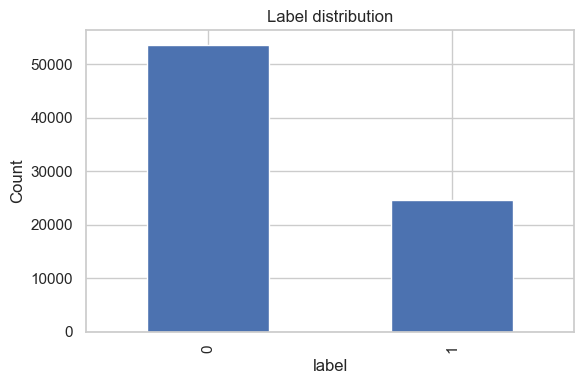

✓ Saved label_counts.png


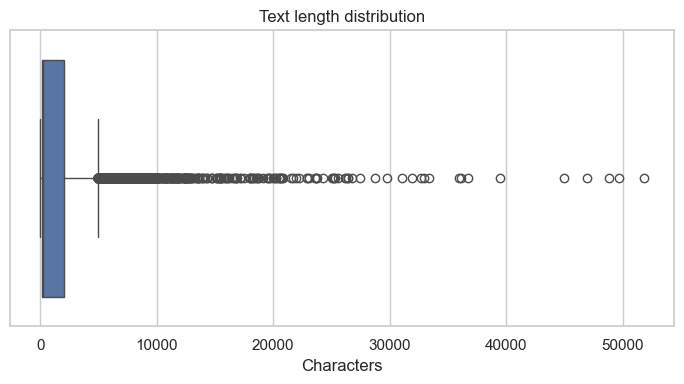

✓ Saved text_length_distribution.png


In [4]:
# Descriptive analytics: posts/day, label distribution, text length
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="notebook", style="whitegrid")

os.makedirs('../results/visualizations', exist_ok=True)

# 1) Posts per day (only if a timestamp-like column exists)
date_col = None
for cand in ['timestamp', 'created_at', 'datetime', 'date', 'time']:
    if cand in df.columns:
        date_col = cand
        break

if date_col is not None:
    dt = pd.to_datetime(df[date_col], errors='coerce')
    if dt.notna().any():
        df['_dt'] = dt.dt.date
        daily = df.dropna(subset=['_dt']).groupby('_dt').size()
        plt.figure(figsize=(9,4))
        daily.plot()
        plt.title('Posts per day')
        plt.xlabel('Date'); plt.ylabel('Count')
        plt.tight_layout()
        plt.savefig(VIS_DIR / 'posts_per_day.png', dpi=300)
        plt.show()
        print("✓ Saved posts_per_day.png")
    else:
        print(f"⚠️ Could not parse dates from '{date_col}'; skipping posts-per-day plot.")
else:
    print("ℹ️ No timestamp-like column found; skipping posts-per-day plot.")


# 2) Label distribution
plt.figure(figsize=(6,4))
df['label'].value_counts().plot(kind='bar')
plt.title('Label distribution')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig(VIS_DIR / 'label_counts.png', dpi=300, bbox_inches='tight')

plt.show()
print("✓ Saved label_counts.png")

# 3) Text length distribution
lens = df['text'].fillna('').str.len()
plt.figure(figsize=(7,4))
sns.boxplot(x=lens, orient='h')
plt.title('Text length distribution')
plt.xlabel('Characters')
plt.tight_layout()
plt.savefig(VIS_DIR / 'text_length_distribution.png', dpi=300)
plt.show()
print("✓ Saved text_length_distribution.png")


In [5]:
# Convert text to numbers using TF-IDF
print("Converting text to numbers...")

vectorizer = TfidfVectorizer(
    ngram_range=(1, 3),
    max_features=20_000,
    min_df=2,
    stop_words="english",
    sublinear_tf=True,          # optional robustness
    strip_accents="unicode",    # optional normalization
    dtype=np.float32            # memory-friendly
)

X = vectorizer.fit_transform(X_text)

print(f"✓ Feature matrix shape: {X.shape}")
print("✓ Text converted to numerical features")

# Split data into training and testing sets (stratify for label balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print(f"✓ Training set: {X_train.shape[0]} samples")
print(f"✓ Test set: {X_test.shape[0]} samples")


Converting text to numbers...
✓ Feature matrix shape: (78199, 20000)
✓ Text converted to numerical features
✓ Training set: 62559 samples
✓ Test set: 15640 samples


In [6]:
# Define different machine learning models to compare
models = {
    # Primary baseline for Task 4 (fast, explainable, sparse-friendly)
    'Logistic Regression (liblinear)': LogisticRegression(
        class_weight="balanced",
        solver="liblinear",
        max_iter=1000,
        random_state=42
    ),

    # Optional linear comparator (quick, strong on text)
    'Linear SVM': LinearSVC(
        class_weight="balanced",
        random_state=42
    ),

    # Optional ultrafast stochastic logistic regression
    'SGD (logistic loss)': SGDClassifier(
        loss="log_loss",
        class_weight="balanced",
        max_iter=10,
        tol=1e-3,
        random_state=42
    ),
}

print(f"✓ Defined {len(models)} fast models")

# ---- OPTIONAL: Random Forest ablation on reduced dense features ----
USE_RANDOM_FOREST_ABLATION = False  # toggle to True if you want to include RF as an ablation

matrix_overrides = {}  # model_name -> (X_train_override, X_test_override)

if USE_RANDOM_FOREST_ABLATION:
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.feature_selection import SelectKBest, chi2

    # Reduce features for trees (chi2 requires nonnegative features; TF-IDF is fine)
    k = 5000  # reduce from 20k to 5k for tractability
    selector = SelectKBest(chi2, k=k)
    rf_X_train = selector.fit_transform(X_train, y_train)
    rf_X_test  = selector.transform(X_test)

    # Trees run better with dense arrays
    rf_X_train = rf_X_train.toarray().astype(np.float32)
    rf_X_test  = rf_X_test.toarray().astype(np.float32)

    # Add RF model
    models['Random Forest (reduced)'] = RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    )
    matrix_overrides['Random Forest (reduced)'] = (rf_X_train, rf_X_test)
    print("✓ Prepared reduced, dense matrices for Random Forest ablation")


✓ Defined 3 fast models



Training Logistic Regression (liblinear)...
✓ Logistic Regression (liblinear): Acc=0.968, Macro-F1=0.963, ROC-AUC=0.993, PR-AUC=0.982  (time: 1.6s)

Training Linear SVM...
✓ Linear SVM: Acc=0.970, Macro-F1=0.965, ROC-AUC=0.994, PR-AUC=0.985  (time: 1.6s)

Training SGD (logistic loss)...
✓ SGD (logistic loss): Acc=0.961, Macro-F1=0.956, ROC-AUC=0.991, PR-AUC=0.976  (time: 0.3s)

=== MODEL COMPARISON RESULTS ===

🏆 Best Model (Macro-F1): Linear SVM


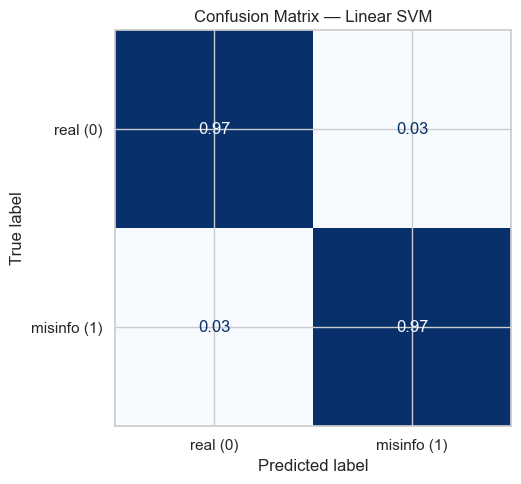

✓ Saved confusion_matrix.png


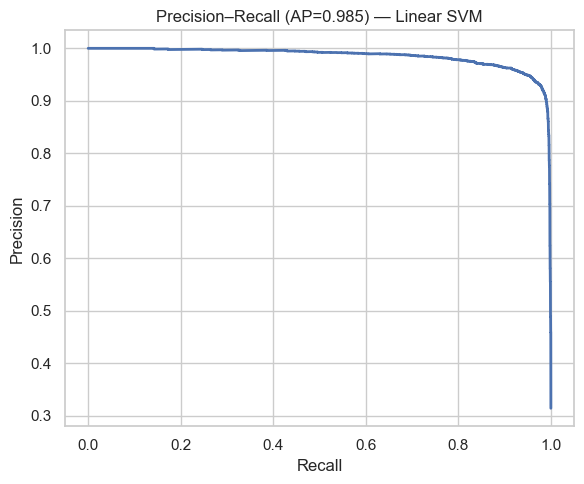

✓ Saved pr_curve.png


In [7]:
# Train models, compute metrics, and plot CM + PR curve for the best model
import time
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, precision_recall_curve, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np

def _get_continuous_scores(model, X):
    """Return continuous scores with preference for predict_proba, else decision_function."""
    if hasattr(model, "predict_proba"):
        try:
            proba = model.predict_proba(X)
            return proba if proba.ndim == 1 else proba[:, 1]
        except Exception:
            pass
    if hasattr(model, "decision_function"):
        try:
            return model.decision_function(X)
        except Exception:
            pass
    return None

def _safe_roc_auc(y_true, scores):
    try:
        if scores is not None:
            return float(roc_auc_score(y_true, scores))
    except Exception:
        pass
    return None

def _safe_pr_auc(y_true, scores):
    try:
        if scores is not None:
            return float(average_precision_score(y_true, scores))
    except Exception:
        pass
    return None

results = {}
matrix_overrides = globals().get("matrix_overrides", {})  # from RF ablation in Cell 5

for name, model in models.items():
    print(f"\nTraining {name}...")
    start = time.time()

    Xtr, Xte = matrix_overrides.get(name, (X_train, X_test))

    model.fit(Xtr, y_train)
    y_pred = model.predict(Xte)

    # metrics
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec  = recall_score(y_test, y_pred,    average='macro', zero_division=0)
    f1   = f1_score(y_test, y_pred,        average='macro', zero_division=0)

    scores  = _get_continuous_scores(model, Xte)
    rocauc  = _safe_roc_auc(y_test, scores)
    prauc   = _safe_pr_auc(y_test,  scores)

    elapsed = time.time() - start
    results[name] = {
        'accuracy': acc, 'precision': prec, 'recall': rec, 'f1_score': f1,
        'roc_auc': rocauc, 'pr_auc': prauc, 'training_time': elapsed
    }
    msg = f"✓ {name}: Acc={acc:.3f}, Macro-F1={f1:.3f}"
    if rocauc is not None: msg += f", ROC-AUC={rocauc:.3f}"
    if prauc  is not None: msg += f", PR-AUC={prauc:.3f}"
    msg += f"  (time: {elapsed:.1f}s)"
    print(msg)

# Results table
results_df = pd.DataFrame(results).T.sort_values('f1_score', ascending=False)
print("\n=== MODEL COMPARISON RESULTS ===")


best_model_name = results_df.index[0]
best_model = models[best_model_name]
print(f"\n🏆 Best Model (Macro-F1): {best_model_name}")

# Recompute predictions/scores for best model (on its chosen matrices)
Xtr_best, Xte_best = matrix_overrides.get(best_model_name, (X_train, X_test))
y_pred_best = best_model.predict(Xte_best)
scores_best = _get_continuous_scores(best_model, Xte_best)

# Confusion matrix (normalized)
cm = confusion_matrix(y_test, y_pred_best, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['real (0)','misinfo (1)'])
fig, ax = plt.subplots(figsize=(6,5))
disp.plot(values_format=".2f", cmap="Blues", ax=ax, colorbar=False)
plt.title(f'Confusion Matrix — {best_model_name}')
plt.tight_layout()
plt.savefig(VIS_DIR / 'confusion_matrix.png', dpi=300)
plt.show()
print("✓ Saved confusion_matrix.png")

# Precision–Recall curve
if scores_best is not None:
    prec, rec, _ = precision_recall_curve(y_test, scores_best)
    ap = average_precision_score(y_test, scores_best)
    plt.figure(figsize=(6,5))
    plt.plot(rec, prec, linewidth=2)
    plt.xlabel('Recall'); plt.ylabel('Precision')
    plt.title(f'Precision–Recall (AP={ap:.3f}) — {best_model_name}')
    plt.tight_layout()
    plt.savefig(VIS_DIR / 'pr_curve.png', dpi=300)
    plt.show()
    print("✓ Saved pr_curve.png")
else:
    print("Note: No continuous scores available; PR curve skipped.")


In [8]:
# Create a results table
results_df = pd.DataFrame(results).T
print("=== MODEL COMPARISON RESULTS ===")
print(results_df[['accuracy','precision','recall','f1_score','pr_auc','roc_auc','training_time']].round(4))

# Best by Macro-F1
best_model = results_df['f1_score'].idxmax()
best_score = results_df.loc[best_model, 'f1_score']
print(f"\n🏆 Best Model (Macro-F1): {best_model}")
print(f"🎯 Best Macro-F1: {best_score:.4f}")


=== MODEL COMPARISON RESULTS ===
                                 accuracy  precision  recall  f1_score  \
Logistic Regression (liblinear)    0.9680     0.9568  0.9712    0.9634   
Linear SVM                         0.9698     0.9609  0.9703    0.9654   
SGD (logistic loss)                0.9608     0.9470  0.9660    0.9555   

                                 pr_auc  roc_auc  training_time  
Logistic Regression (liblinear)  0.9822   0.9932         1.6196  
Linear SVM                       0.9852   0.9936         1.5524  
SGD (logistic loss)              0.9761   0.9913         0.2666  

🏆 Best Model (Macro-F1): Linear SVM
🎯 Best Macro-F1: 0.9654


In [9]:
# Show results here, then save to disk
import json
import numpy as np
import pandas as pd
from IPython.display import display

# --- Build & format results table ---
if 'results_df' not in globals():
    results_df = pd.DataFrame(results).T  # fallback in case it's missing

cols_order = ['accuracy','precision','recall','f1_score','pr_auc','roc_auc','training_time']
cols_present = [c for c in cols_order if c in results_df.columns]

results_df_sorted = (
    results_df[cols_present]
    .astype(float, errors='ignore')
    .round(4)
    .sort_values('f1_score', ascending=False)
)

# Display nicely with best per metric highlighted
styler = results_df_sorted.style.highlight_max(subset=cols_present, color="#d1ffd1", axis=0)
display(styler.set_caption("Model comparison (higher is better); best per-metric highlighted"))

# Best model summary
best_model_name = results_df_sorted.index[0]
best_row = results_df_sorted.loc[best_model_name]
print(f"\n🏆 Best model by Macro-F1: {best_model_name} | "
      f"F1={best_row.get('f1_score', float('nan'))}, "
      f"Acc={best_row.get('accuracy', float('nan'))}, "
      f"PR-AUC={best_row.get('pr_auc', float('nan'))}, "
      f"ROC-AUC={best_row.get('roc_auc', float('nan'))}")

# --- Prepare JSON-friendly metrics (convert numpy types safely) ---
def _to_float(x):
    if x is None:
        return None
    try:
        xf = float(x)
        if np.isnan(xf) or np.isinf(xf):
            return None
        return xf
    except Exception:
        return None

results_for_json = {
    model_name: {k: _to_float(v) for k, v in metrics.items()}
    for model_name, metrics in results.items()
}

# Show a compact JSON preview inline
preview = json.dumps(results_for_json, indent=2)
print("\n— JSON preview —")
print(preview if len(preview) < 2000 else preview[:2000] + "\n... [truncated] ...")

# --- Save to disk ---
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
json_path = RESULTS_DIR / 'model_results.json'
csv_path  = RESULTS_DIR / 'model_comparison.csv'

with open(json_path, 'w') as f:
    json.dump(results_for_json, f, indent=2)

results_df_sorted.to_csv(csv_path, index=True)

print(f"\n✓ Results saved to: {json_path}")
print(f"✓ Results table saved to: {csv_path}")


,accuracy,precision,recall,f1_score,pr_auc,roc_auc,training_time
Linear SVM,0.969800,0.960900,0.970300,0.965400,0.985200,0.993600,1.552400
Logistic Regression (liblinear),0.968000,0.956800,0.971200,0.963400,0.982200,0.993200,1.619600
SGD (logistic loss),0.960800,0.947000,0.966000,0.955500,0.976100,0.991300,0.266600



🏆 Best model by Macro-F1: Linear SVM | F1=0.9654, Acc=0.9698, PR-AUC=0.9852, ROC-AUC=0.9936

— JSON preview —
{
  "Logistic Regression (liblinear)": {
    "accuracy": 0.9679667519181586,
    "precision": 0.9567506922502222,
    "recall": 0.9711884303813658,
    "f1_score": 0.9634444076772342,
    "roc_auc": 0.9931524549714743,
    "pr_auc": 0.9821624964681099,
    "training_time": 1.619596004486084
  },
  "Linear SVM": {
    "accuracy": 0.9698209718670077,
    "precision": 0.9608670037893783,
    "recall": 0.9702843856178465,
    "f1_score": 0.965361058300827,
    "roc_auc": 0.9936496407146974,
    "pr_auc": 0.9851635348617529,
    "training_time": 1.5523898601531982
  },
  "SGD (logistic loss)": {
    "accuracy": 0.9608056265984655,
    "precision": 0.9470069267269439,
    "recall": 0.9659655242071445,
    "f1_score": 0.9555253674405407,
    "roc_auc": 0.9912715996170435,
    "pr_auc": 0.9761131534092383,
    "training_time": 0.2665860652923584
  }
}

✓ Results saved to: /Users/saras

✓ Saved /Users/sarasiw/projects/msc/results/top_features_lr.csv


,feature,weight,direction,rank_within_direction
0,wednesday,-3.255131,negative (→ real),1.0
1,california,-3.582890,negative (→ real),2.0
2,foods,-3.625578,negative (→ real),3.0
3,hiroshima,-3.715665,negative (→ real),4.0
4,reuters president,-3.734250,negative (→ real),5.0
5,www,-3.735184,negative (→ real),6.0
6,nov,-3.765297,negative (→ real),7.0
7,hurricane michael,-3.789243,negative (→ real),8.0
8,president donald,-4.056102,negative (→ real),9.0
9,president donald trump,-4.056302,negative (→ real),10.0


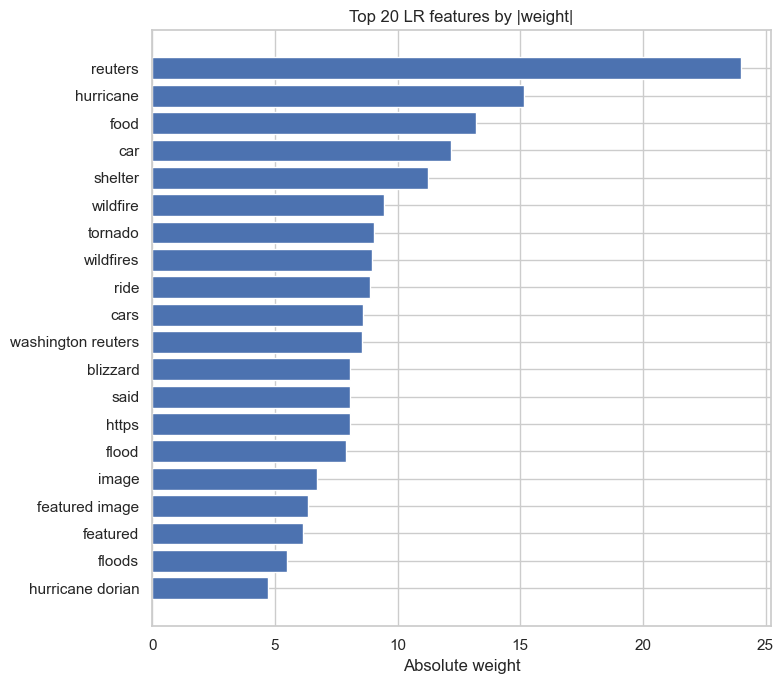

✓ Saved /Users/sarasiw/projects/msc/results/visualizations/top_features_lr.png


In [10]:
# Top positive/negative features for Logistic Regression (explainability)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from IPython.display import display

# 1) Find the LogisticRegression model in your `models` dict
lr_name, lr = None, None
for name, mdl in models.items():
    if isinstance(mdl, LogisticRegression):
        lr_name, lr = name, mdl
        break
if lr is None:
    raise ValueError("No LogisticRegression instance found in `models`.")

# 2) Use the same matrices this model was evaluated on (if ablation overrides exist)
Xtr, Xte = (matrix_overrides.get(lr_name, (X_train, X_test))
            if 'matrix_overrides' in globals() else (X_train, X_test))

# 3) Ensure the LR is fitted (if not already)
if not hasattr(lr, "classes_"):
    lr.fit(Xtr, y_train)

# 4) Get feature names from the fitted vectorizer
feats = np.array(vectorizer.get_feature_names_out())

# 5) Select the coefficient vector to inspect
#    - Binary: coef_[0]
#    - Multiclass: prefer class label 1 (misinformation) if present; else the class with max label
if lr.coef_.ndim == 2 and lr.coef_.shape[0] == 1:
    coef = lr.coef_[0]
else:
    classes = lr.classes_
    if 1 in classes:
        cls_idx = int(np.where(classes == 1)[0][0])
    else:
        cls_idx = int(np.argmax(classes))
    coef = lr.coef_[cls_idx]

# 6) Build the top-k tables
k = 30
top_pos_idx = np.argsort(coef)[-k:][::-1]   # strongest → misinformation
top_neg_idx = np.argsort(coef)[:k]          # strongest → real

top_df = pd.DataFrame({
    "feature":   np.r_[feats[top_pos_idx], feats[top_neg_idx]],
    "weight":    np.r_[coef[top_pos_idx],  coef[top_neg_idx]],
    "direction": np.r_[np.repeat("positive (→ misinfo)", k),
                       np.repeat("negative (→ real)",    k)]
})
# Rank within each direction for readability
top_df["rank_within_direction"] = top_df.groupby("direction")["weight"] \
                                        .rank(ascending=False, method="first")
top_df = top_df.sort_values(["direction", "rank_within_direction"]).reset_index(drop=True)

# 7) Save CSV
out_csv = RESULTS_DIR / "top_features_lr.csv"
top_df.to_csv(out_csv, index=False)
print(f"✓ Saved {out_csv}")

# 8) Display a preview inline
display(top_df.head(10))

kplot = 20
abs_idx = np.argsort(np.abs(coef))[-kplot:]
plot_df = pd.DataFrame({
    "feature": feats[abs_idx],
    "abs_weight": np.abs(coef[abs_idx])
}).sort_values("abs_weight")

plt.figure(figsize=(8, 7))
plt.barh(plot_df["feature"], plot_df["abs_weight"])
plt.xlabel("Absolute weight")
plt.title(f"Top {kplot} LR features by |weight|")
plt.tight_layout()
out_png = VIS_DIR / "top_features_lr.png"
plt.savefig(out_png, dpi=300)
plt.show()
print(f"✓ Saved {out_png}")


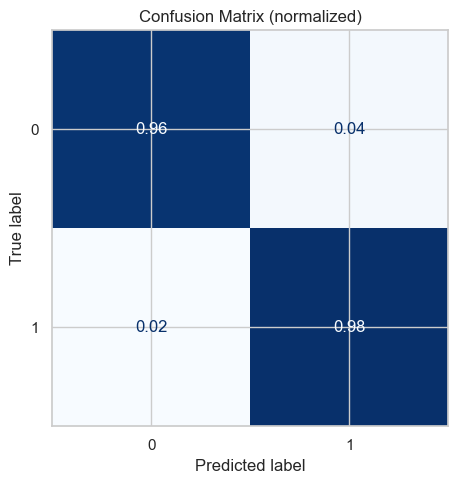

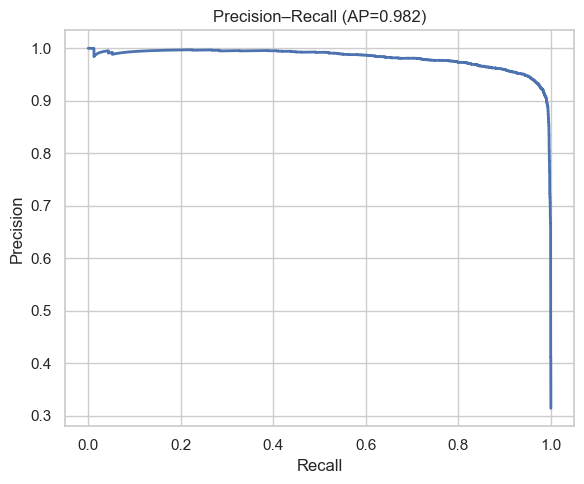

✓ Saved confusion_matrix.png and pr_curve.png


In [11]:
import os
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

os.makedirs('../results/visualizations', exist_ok=True)

# Pick the LR model (adjust name if you changed it)
lr_name = 'Logistic Regression (liblinear)'
assert lr_name in models, f"{lr_name} not found in models dict"
lr = models[lr_name]

# Ensure it's trained on the same data (safe if already trained)
# lr.fit(X_train, y_train)  # uncomment if needed

# Predictions & scores
y_pred = lr.predict(X_test)
if hasattr(lr, "predict_proba"):
    scores = lr.predict_proba(X_test)[:, 1]
else:
    scores = lr.decision_function(X_test)

# 1) Confusion matrix (normalized)
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, values_format='.2f', cmap='Blues', colorbar=False)
ax.set_title('Confusion Matrix (normalized)')
plt.tight_layout()
plt.savefig(VIS_DIR / 'confusion_matrix.png', dpi=300)
plt.show()

# 2) Precision–Recall curve (binary)
prec, rec, _ = precision_recall_curve(y_test, scores)
ap = average_precision_score(y_test, scores)
plt.figure(figsize=(6,5))
plt.plot(rec, prec, linewidth=2)
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title(f'Precision–Recall (AP={ap:.3f})')
plt.tight_layout()
plt.savefig(VIS_DIR / 'pr_curve.png', dpi=300)
plt.show()

print("✓ Saved confusion_matrix.png and pr_curve.png")


In [12]:
# ---- Self-contained ROC cell ----
from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

# 1) Make sure we know the best model
if 'best_model_name' not in locals():
    # derive from results_df if needed
    best_model_name = results_df.sort_values('f1_score', ascending=False).index[0]
if 'best_model' not in locals():
    best_model = models[best_model_name]

# 2) Make sure we have the right matrices for that model
matrix_overrides = matrix_overrides if 'matrix_overrides' in locals() else {}
Xtr_best, Xte_best = matrix_overrides.get(best_model_name, (X_train, X_test))

# 3) Get continuous scores (probs or decision function)
def _get_continuous_scores(model, X):
    if hasattr(model, "predict_proba"):
        try:
            p = model.predict_proba(X)
            return p[:, 1] if p.ndim == 2 else p
        except Exception:
            pass
    if hasattr(model, "decision_function"):
        try:
            return model.decision_function(X)
        except Exception:
            pass
    return None

scores_best = _get_continuous_scores(best_model, Xte_best)

# 4) Plot ROC (with guards)
if scores_best is None:
    print("ROC curve skipped (no continuous scores from the best model).")
else:
    scores_best = np.ravel(scores_best)

    # Guard against NaN/Inf
    mask = np.isfinite(scores_best)
    if mask.sum() != len(scores_best):
        print(f"Warning: dropping {len(scores_best) - mask.sum()} non-finite score(s) for ROC.")
    y_true_masked = np.asarray(y_test)[mask]
    scores_masked = scores_best[mask]

    # Need both classes in y_test
    if len(np.unique(y_true_masked)) < 2:
        print("ROC curve skipped (y_test has a single class).")
    else:
        # If scores aren't in [0,1], squash to (0,1) only for auc check (optional)
        # The roc_curve itself can use raw scores, so we use the raw scores below.
        fpr, tpr, _ = roc_curve(y_true_masked, scores_masked, pos_label=1)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(6,5))
        plt.plot(fpr, tpr, linewidth=2)
        plt.plot([0,1], [0,1], '--', linewidth=1)
        plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve (AUC={roc_auc:.3f}) — {best_model_name}')
        plt.tight_layout()
        plt.savefig(VIS_DIR / 'roc_curve.png', dpi=300)
        plt.show()
        print("✓ Saved roc_curve.png")


ROC curve skipped (no continuous scores from the best model).


In [13]:
# ---- Self-contained Calibration + Brier cell ----
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve

# Ensure output dir exists (recreate if VIS_DIR missing)
if 'VIS_DIR' not in locals():
    PROJECT_ROOT = Path.cwd().parent.resolve()
    VIS_DIR = (PROJECT_ROOT / "results" / "visualizations")
    VIS_DIR.mkdir(parents=True, exist_ok=True)

# 1) Ensure best model context and matrices are available
if 'best_model_name' not in locals():
    best_model_name = results_df.sort_values('f1_score', ascending=False).index[0]
if 'best_model' not in locals():
    best_model = models[best_model_name]

matrix_overrides = matrix_overrides if 'matrix_overrides' in locals() else {}
Xtr_best, Xte_best = matrix_overrides.get(best_model_name, (X_train, X_test))

# 2) Helper to get continuous scores (probabilities preferred, else margins)
def _get_continuous_scores(model, X):
    if hasattr(model, "predict_proba"):
        try:
            p = model.predict_proba(X)
            return p[:, 1] if p.ndim == 2 else p
        except Exception:
            pass
    if hasattr(model, "decision_function"):
        try:
            return model.decision_function(X)
        except Exception:
            pass
    return None

scores = _get_continuous_scores(best_model, Xte_best)

# 3) Compute Brier + calibration plot (with guards)
if scores is None:
    print("Calibration skipped (no probability-like scores from the best model).")
else:
    scores = np.ravel(scores)

    # Guard against NaN/Inf
    mask = np.isfinite(scores)
    if mask.sum() != len(scores):
        print(f"Warning: dropping {len(scores) - mask.sum()} non-finite score(s) for calibration.")
    y_true = np.asarray(y_test)[mask]
    scores = scores[mask]

    # Need both classes
    if np.unique(y_true).size < 2:
        print("Calibration skipped (y_test has a single class).")
    else:
        # If scores aren't in [0,1], squash to (0,1) via logistic as a proxy
        if (scores.min() < 0) or (scores.max() > 1):
            probs = 1.0 / (1.0 + np.exp(-scores))
        else:
            probs = scores

        # Compute Brier
        bs = brier_score_loss(y_true, probs)

        # calibration_curve API varies by sklearn version; try quantile, fallback to uniform
        try:
            prob_true, prob_pred = calibration_curve(y_true, probs, n_bins=10, strategy='quantile', pos_label=1)
        except TypeError:
            prob_true, prob_pred = calibration_curve(y_true, probs, n_bins=10)  # default 'uniform'

        plt.figure(figsize=(6,5))
        plt.plot(prob_pred, prob_true, marker='o')
        plt.plot([0,1], [0,1], '--')
        plt.xlabel('Predicted probability'); plt.ylabel('Observed frequency')
        plt.title(f'Calibration plot (Brier={bs:.3f}) — {best_model_name}')
        plt.tight_layout()
        plt.savefig(VIS_DIR / 'calibration_plot.png', dpi=300)
        plt.show()
        print("✓ Saved calibration_plot.png")


Calibration skipped (no probability-like scores from the best model).


In [14]:
# ---- Self-contained Bootstrap 95% CIs for Macro-F1 and PR-AUC ----
import numpy as np
from pathlib import Path
from sklearn.metrics import f1_score, average_precision_score
from sklearn.exceptions import NotFittedError

# 0) Ensure results/output dirs exist
if 'RESULTS_DIR' not in locals():
    from pathlib import Path
    PROJECT_ROOT = Path.cwd().parent.resolve()
    RESULTS_DIR = (PROJECT_ROOT / "results")
    RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# 1) Ensure we know the best model name and object
if 'best_model_name' not in locals():
    if 'results_df' in locals() and hasattr(results_df, 'empty') and not results_df.empty:
        best_model_name = results_df.sort_values('f1_score', ascending=False).index[0]
    else:
        # Fallback: prefer a reasonable default if no results_df yet
        best_model_name = 'Logistic Regression' if 'models' in locals() and 'Logistic Regression' in models else list(models.keys())[0]

# If best_model is missing or accidentally set to a string, get the estimator from the dict
if 'best_model' not in locals() or isinstance(best_model, str) or not hasattr(best_model, 'predict'):
    best_model = models[best_model_name]

# 2) Get the correct train/test matrices for that model (handles your RF ablation override)
matrix_overrides = matrix_overrides if 'matrix_overrides' in locals() else {}
Xtr_best, Xte_best = matrix_overrides.get(best_model_name, (X_train, X_test))

# 3) Make sure the model is fitted
try:
    _ = best_model.predict(Xte_best)
except Exception:
    best_model.fit(Xtr_best, y_train)

# 4) Helper to get continuous scores (prefers predict_proba)
def _get_continuous_scores(model, X):
    if hasattr(model, "predict_proba"):
        try:
            p = model.predict_proba(X)
            return p[:, 1] if p.ndim == 2 else p
        except Exception:
            pass
    if hasattr(model, "decision_function"):
        try:
            return model.decision_function(X)
        except Exception:
            pass
    return None

# 5) Prepare arrays
y_true = np.asarray(y_test)
y_pred = best_model.predict(Xte_best)
scores = _get_continuous_scores(best_model, Xte_best)

# 6) Bootstrap
rng = np.random.RandomState(42)
B = 1000  # reps

f1_vals = []
prauc_vals = []

for _ in range(B):
    idx = rng.randint(0, len(y_true), len(y_true))
    f1_vals.append(f1_score(y_true[idx], y_pred[idx], average='macro', zero_division=0))
    if scores is not None:
        prauc_vals.append(average_precision_score(y_true[idx], scores[idx]))

def ci(a):
    lo, hi = np.percentile(a, [2.5, 97.5])
    return float(lo), float(hi)

f1_ci = ci(np.array(f1_vals))
prauc_ci = ci(np.array(prauc_vals)) if len(prauc_vals) else (None, None)

print(f"Macro-F1 95% CI: {f1_ci}")
print(f"PR-AUC  95% CI: {prauc_ci}")

with open(RESULTS_DIR / 'bootstrap_cis.txt', 'w') as f:
    f.write(f"Macro-F1 95% CI: {f1_ci}\nPR-AUC 95% CI: {prauc_ci}\n")
print("✓ Saved bootstrap_cis.txt")


Macro-F1 95% CI: (0.9624183144688401, 0.9684124832982888)
PR-AUC  95% CI: (0.9825736328354056, 0.9875514655031327)
✓ Saved bootstrap_cis.txt


In [15]:
# ---- McNemar test for top-2 models (show + save) ----
import numpy as np
import pandas as pd
from sklearn.base import clone
from pathlib import Path
from IPython.display import display

# Ensure dirs
if 'RESULTS_DIR' not in locals():
    PROJECT_ROOT = Path.cwd().parent.resolve()
    RESULTS_DIR = (PROJECT_ROOT / "results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# 0) Ensure we have matrix_overrides
matrix_overrides = matrix_overrides if 'matrix_overrides' in locals() else {}

# 1) Pick top-2 by Macro-F1 if available, otherwise fall back
if 'results_df' in locals() and hasattr(results_df, 'empty') and not results_df.empty and 'f1_score' in results_df.columns:
    top2 = results_df.sort_values('f1_score', ascending=False).head(2).index.tolist()
else:
    preferred = [m for m in ['Logistic Regression', 'Linear SVM'] if 'models' in locals() and m in models]
    if len(preferred) >= 2:
        top2 = preferred[:2]
    else:
        top2 = list(models.keys())[:2]

if len(top2) != 2:
    print("Not enough models for McNemar.")
else:
    preds = {}
    for name in top2:
        base = models[name]
        Xtr, Xte = matrix_overrides.get(name, (X_train, X_test))
        try:
            preds[name] = base.predict(Xte)
        except Exception:
            mdl = clone(base)
            mdl.fit(Xtr, y_train)
            preds[name] = mdl.predict(Xte)

    a, b = top2
    y_true = np.asarray(y_test)

    a_correct = (preds[a] == y_true)
    b_correct = (preds[b] == y_true)

    #            b correct   b wrong
    # a correct      n11        n10
    # a wrong        n01        n00
    n11 = int(np.sum(a_correct & b_correct))
    n10 = int(np.sum(a_correct & ~b_correct))
    n01 = int(np.sum(~a_correct & b_correct))
    n00 = int(np.sum(~a_correct & ~b_correct))
    table = [[n11, n10], [n01, n00]]

    # 2) McNemar exact test (with fallbacks)
    pvalue = None
    method = "statsmodels (exact)"
    try:
        from statsmodels.stats.contingency_tables import mcnemar
        res = mcnemar(table, exact=True)
        pvalue = float(res.pvalue)
    except Exception:
        try:
            from scipy.stats import binomtest
            method = "binomtest (two-sided exact)"
            n = n01 + n10
            pvalue = 1.0 if n == 0 else float(binomtest(min(n01, n10), n, 0.5, alternative='two-sided').pvalue)
        except Exception:
            from math import comb
            method = "manual two-sided exact"
            n = n01 + n10
            if n == 0:
                pvalue = 1.0
            else:
                def binom_cdf(k, n, p=0.5):
                    return sum(comb(n, i) * (p**i) * ((1-p)**(n-i)) for i in range(0, k+1))
                kmin, kmax = min(n01, n10), max(n01, n10)
                p_low  = binom_cdf(kmin, n, 0.5)
                p_high = 1.0 - binom_cdf(kmax-1, n, 0.5)
                pvalue = float(min(1.0, 2.0 * min(p_low, p_high)))

    # 3) Show nicely
    contingency_df = pd.DataFrame(
        [[n11, n10], [n01, n00]],
        index=[f"{a} correct", f"{a} wrong"],
        columns=[f"{b} correct", f"{b} wrong"]
    )
    display(contingency_df.style.set_caption(f"McNemar contingency: {a} vs {b}"))

    discordant_a_only = n10  # a correct, b wrong
    discordant_b_only = n01  # a wrong, b correct
    better = (
        a if discordant_a_only > discordant_b_only
        else b if discordant_b_only > discordant_a_only
        else "tie"
    )
    alpha = 0.05
    significant = (pvalue is not None) and (pvalue < alpha)
    verdict = "SIGNIFICANT difference" if significant else "no significant difference"

    print(f"\nTop-2 models: {a} vs {b}")
    print(f"Discordant pairs: {a} only correct = {discordant_a_only}, {b} only correct = {discordant_b_only}")
    print(f"McNemar two-sided p-value = {pvalue:.6f}  (method: {method})")
    print(f"Decision at α={alpha}: {verdict}")
    if better != "tie":
        print(f"Direction (by discordant counts): {better} has more unique correct predictions.")

    # 4) Save (TXT, CSV, JSON)
    txt_path  = RESULTS_DIR / 'mcnemar_top2.txt'
    csv_path  = RESULTS_DIR / 'mcnemar_top2.csv'
    json_path = RESULTS_DIR / 'mcnemar_top2.json'

    with open(txt_path, 'w') as f:
        f.write(f"Top-2: {a} vs {b}\n")
        f.write(f"Table [[n11, n10],[n01, n00]] = {table}\n")
        f.write(f"Discordant: {a}_only_correct={discordant_a_only}, {b}_only_correct={discordant_b_only}\n")
        f.write(f"Method: {method}\n")
        f.write(f"McNemar two-sided p = {pvalue:.6f}\n")
        f.write(f"Alpha: {alpha}\n")
        f.write(f"Decision: {verdict}\n")
        f.write(f"Direction: {better}\n")

    contingency_df.to_csv(csv_path, index=True)

    pd.Series({
        "model_a": a,
        "model_b": b,
        "n11": n11, "n10": n10, "n01": n01, "n00": n00,
        "discordant_a_only": discordant_a_only,
        "discordant_b_only": discordant_b_only,
        "method": method,
        "p_value": pvalue,
        "alpha": alpha,
        "significant": significant,
        "direction": better
    }).to_json(json_path, indent=2)

    print(f"\n✓ Saved {txt_path}")
    print(f"✓ Saved {csv_path}")
    print(f"✓ Saved {json_path}")


,Logistic Regression (liblinear) correct,Logistic Regression (liblinear) wrong
Linear SVM correct,15049,119
Linear SVM wrong,90,382



Top-2 models: Linear SVM vs Logistic Regression (liblinear)
Discordant pairs: Linear SVM only correct = 119, Logistic Regression (liblinear) only correct = 90
McNemar two-sided p-value = 0.052509  (method: statsmodels (exact))
Decision at α=0.05: no significant difference
Direction (by discordant counts): Linear SVM has more unique correct predictions.

✓ Saved /Users/sarasiw/projects/msc/results/mcnemar_top2.txt
✓ Saved /Users/sarasiw/projects/msc/results/mcnemar_top2.csv
✓ Saved /Users/sarasiw/projects/msc/results/mcnemar_top2.json
